In [8]:
# import libraries
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
import re
import math
import time
import glob
import gzip
import sys
import matplotlib.pyplot as plt
import matplotlib
import os
import random
import h5py
import sklearn.metrics

folder_fig="figuras/conv7_MDN"

## Declaramos el Dataloader que se ha usado para entrenar la red

In [9]:
class EventsData(Dataset):
    def __init__(self,data_dir,per=100,batch_size=500):
        # Save the directory of the data
        self.data_dir = data_dir
        
        # Get the names of the files
        self.names=glob.glob(str(data_dir)+'*.hdf5')
        # Number of files in the dir
        self.size_dir=len(self.names)
        
        # Set the files acording to the percentage
        self.size_dir=math.ceil(len(self.names)*(per/100))
        self.names=self.names[0:self.size_dir]
        #random.shuffle(self.names)
        
        # Get the number of events per file
        print(self.names[1])
        f = h5py.File(self.names[0],'r')
        self.size_file=f['y'].shape[0]
        
        # Get the total number of events
        self.total_events=0
        for name in self.names:
            f = h5py.File(name,'r')
            y = f['y']
            self.total_events+=y.shape[0]
            
        # Load the whole dataset into the RAM
        self.data_big = torch.zeros(self.total_events,25,161)
        self.target_big = torch.zeros(self.total_events)

        print("Reading "+str(self.data_dir)+" with "+str(self.size_dir)+" files.")
        for a in range(len(self.names)):
            f = h5py.File(self.names[a],'r')
            self.data_big[(a*1000):(((a+1)*1000))]=torch.tensor(f['X1'][:,:,:,0])
            self.target_big[(a*1000):(((a+1)*1000))]=torch.tensor(f['y'][:,0])
            
            
        # Number of iterations to finish the dataset
        self.batch_size=batch_size
        self.iters=math.floor(self.total_events/batch_size)
        self.iters_per_file= math.floor(self.size_file/batch_size)
        self.real_events=self.batch_size*self.iters

        print("There are "+str(self.total_events)+" events.")
        print("In "+str(self.size_dir)+" separate files.")
        print("Each file containing "+str(self.size_file)+" events.")
        print("In "+str(self.iters)+" iterations")
        print("The real number of events is: "+str(self.real_events))
        


    def get_len(self):
        return self.real_events
    
    def get_iter(self):
        # Returns the number of iteracions og getitem to finish the dataset
        return self.iters

    def get_batch(self, idx):
        # Get the file that shall be opened
        ind1=idx*self.batch_size
        ind2=((idx+1)*self.batch_size)
        
        #print(ind1)
        #print(ind2)
        
        data=self.data_big[ind1:ind2,:,:]
        target=self.target_big[ind1:ind2]
        
        # Get the events that will be extracted from the file
        #ind2=ind+self.batch_size
        
        data=data.unsqueeze(dim=3)
        target=target.unsqueeze(dim=1)
        
        #Only for conv with modulus
        data=data.transpose(1,3)
        data=data.transpose(2,3)
        
        
        #target[:,0]=torch.tensor(f['y'][ind:ind2,0])
        target=torch.arccos(target)*(180.0/math.pi)
    
        
        return data.float(),target.float()

In [10]:
# Iniciamos el dataloader, pero solo el de test
print("Test dataset:")
test_data=EventsData(data_dir='Mod_full/test_data_fixed/', per=100, batch_size=1000);
print()

Test dataset:
Mod_full/test_data_fixed/test_dataset_17.hdf5
Reading Mod_full/test_data_fixed/ with 121 files.
There are 121000 events.
In 121 separate files.
Each file containing 1000 events.
In 121 iterations
The real number of events is: 121000



## Declaramos la arquitectura de nuestra red, tiene que ser exactamente igual a que vamos a evaluar

In [11]:
def get_prediction(mu,sigma,pi):
    # Se obtiene una distribución polinomial
    # Esto esta en el github
    # k = torch.multinomial(pi, 1).view(-1)
    #print("Mu tensor size")
    #print(mu.size())
    #print("Pi tensor size")
    #print(pi.size())
    # Mas facil
    k = torch.argmax(pi,dim=1)
    
    #y_pred=torch.ones([100,1])
    y_pred = mu[np.arange(1000), k].unsqueeze(dim=1)
    sigma = sigma[np.arange(1000), k].unsqueeze(dim=1)
    
    return y_pred,sigma

In [14]:
# This class will contain the NN arquitecture, it will be pushed to the GPU
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Capas convolucionales
        kernel_size=(2,10)
        
        #conv layer, sees 25x161x1 tensor
        self.conv1 = nn.Conv2d(1, 16, kernel_size,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size,padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size,padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size,padding=1)
        self.pool = nn.MaxPool2d((2, 2))

        # Capa de entrada, le entra el valor de x
        self.input_flatten = 6656
        h1 = 600
        h2 = 200

        n_gaussians = 20
        
        self.fc1 = nn.Linear(self.input_flatten,h1)
        self.fc2 = nn.Linear(h1,h2)
        
        
        # Capas para las 3 salidas
        
        self.mu = nn.Linear(h2, n_gaussians)
        self.sigma = nn.Linear(h2, n_gaussians)
        self.pi = nn.Linear(h2, n_gaussians)
        
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.reshape(-1, self.input_flatten)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
#        x = F.relu(self.fc3(x))
#        x = self.dropout(x)
        
        mu = self.mu(x)
        #sigma = self.sigma(x)
        sigma = torch.exp(self.sigma(x))
        #sigma = (F.elu(self.sigma(x))+1.0001)
        pi = F.softmax(self.pi(x), -1)
        return mu,sigma,pi

## Pasamos los datos a la red, podemos seleccionar:
* La carpeta donde está el archivo
* El nombre del archivo que vamos a cargar
* El dispositivo donde vamos a correr la red: cuda o cpu

In [16]:
# Check if cuda is available and set as default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=Net()
print(net)
net.cuda()
# Cargar aqui el archivo
net.load_state_dict(torch.load('Conv7_MDN_Rial2/Conv7_MDN_Full_exp_1.pt'))
net.eval()
# This is where the values will be stored
target_temp=np.zeros([test_data.get_len(),1])
mu_temp=np.zeros([test_data.get_len(),1])
sigma_temp=np.zeros([test_data.get_len(),1])
MAE=0
MSE=0
for batch in range(test_data.get_iter()):
    # Get the data
    data,target = test_data.get_batch(batch)
    # move tensors to GPU if CUDA is available
    data = data.cuda()
    # Get the results from the foward pass to the CPU 
    # And get it as an numpy matrix
    mu,sigma,pi = net(data)
    mu_selected,sigma_selected = get_prediction(mu,sigma,pi)
    # Get from tensors to numpy
    
    output = mu_selected.cpu().detach().numpy()
    sigma = sigma_selected.detach().cpu().numpy()
    target = target.numpy()
    # calculate the batch loss
    MAE += np.sum(np.abs(output-target))
    MSE += np.sum((output-target)**2)
    # Append to the historical value
    target_temp[(batch*1000):((batch+1)*1000)]=target
    sigma_temp[(batch*1000):((batch+1)*1000)]=sigma
    mu_temp[(batch*1000):((batch+1)*1000)]=output
    
# Sacamos el error, solo para comprobar que es parecido a los resultados anteriores
MAE = MAE/test_data.get_len()
RMSE = np.sqrt(MSE/test_data.get_len())

print("The MAE is "+str(MAE))
print("The RMSE is "+str(RMSE))

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6656, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (mu): Linear(in_features=200, out_features=20, bias=True)
  (sigma): Linear(in_features=200, out_features=20, bias=True)
  (pi): Linear(in_features=200, out_features=20, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
The MAE is 58.65313313533058
The RMSE is 70.20183246177935


## Extraemos y recalculamos los valores 
1. Primero de los archivos de test, la energía y la z del BBFit
2. Recalculamos las componentes Z
3. Convertimos algunas variables para que tengan los mismos nombres

In [17]:
# De los archivos, vamos a extraer la energía y el BBFIT
# Ya que el dataloader no nos los dá
f = h5py.File(test_data.names[0],'r')

# Inicializamos las matrices
test_z=f['y'][:,0] # Guardamos la componente z
energy=f['y'][:,1] # Guardamos la energía
bbfit_uz=f['X2'][:,0] # Guardamos la componente z del BBFIT
txi2 = f["X2"][:,-1]

# Miramos el dataset entero ampliando las matrices
for name in test_data.names[1:]:
    f = h5py.File(name,'r')
    test_z_aux=f['y'][:,0] # Guardamos la componente z
    energy_aux=f['y'][:,1] # Guardamos la energía
    bbfit_uz_aux=f['X2'][:,0] # Guardamos la componente z del BBFIT
    txi2_aux = f["X2"][:,-1]
    
    # Juntamos las matrices
    test_z = np.append(test_z,test_z_aux,axis=0)
    energy = np.append(energy,energy_aux,axis=0)
    bbfit_uz = np.append(bbfit_uz,bbfit_uz_aux,axis=0)
    txi2 = np.append(txi2,txi2_aux,axis=0)
    

In [18]:

# Zenith y desviación
# Recordar que la red saca los valores en radianes
zenith_p = mu_temp * (180.0/np.pi)
zenith_std = sigma_temp * (180.0/np.pi)

# Calculamos los valores de Z
zeta = np.cos((zenith_p*math.pi)/180.0)
zeta_std = sigma_temp*np.sin(mu_temp)

# Le damos una dimension más
true_z = np.expand_dims(test_z,axis=1)
bbfit_uz = np.expand_dims(bbfit_uz,axis=1)

# Calculamos los errores
zeta_error =  zeta - true_z
bbfit_zeta_error = bbfit_uz - true_z

zeta_error_abs = np.abs(zeta_error)
bbfit_zeta_error_abs = np.abs(bbfit_zeta_error)


# Zenith reales (zenith_true)
zenith_t = np.arccos(true_z) * (180/np.pi)
#zenith_t = np.expand_dims(zenith_t,axis=1)

# Zenith BBfit
bbfit_z_p = np.arccos(bbfit_uz) * (180/np.pi)
#bbfit_z_p = np.expand_dims(bbfit_z_p,axis=1)

## Obteniendo las métricas de MAE y RMSE

In [ ]:
print('Metrics Zenith: MAE, RMSE')
metrics = np.zeros((2,2), dtype = np.float32)
metrics[0,0] = mean_absolute_error(zenith_t, zenith_p)  # MAE Zenith
metrics[1,0] = mean_absolute_error(zenith_t, bbfit_z_p) # MAE BBift Zenith

metrics[0,1] = mean_squared_error(zenith_t, zenith_p, squared = False)  # RMSE Zenith
metrics[1,1] = mean_squared_error(zenith_t, bbfit_z_p, squared = False)# RMSE BBfit Zenith


metrics

Metrics Zenith: MAE, RMSE


NameError: ignored

In [ ]:
print('Metrics Z:')
metrics = np.zeros((2,2), dtype = np.float32)
metrics[0,0] = mean_absolute_error(test_z, zeta) # MAE Z
metrics[1,0] = mean_absolute_error(test_z, bbfit_uz)          # MAE BBift Z

metrics[0,1] = mean_squared_error(test_z, zeta, squared = False) # RMSE Z
metrics[1,1] = mean_squared_error(test_z, bbfit_uz, squared = False)          # RMSE BBfit Z


metrics

Metrics Z:


NameError: ignored

### Errores en ángulos y variable chi$^2$

In [19]:
a=np.expand_dims(zenith_t,axis=1)

# Errores en zenith sin valor absoluto
z_error = zenith_p - zenith_t

# Error en zenith de BBfit sin valor absoluto
bbfit_z_error = bbfit_z_p - zenith_t

# Errores absolutos en zenith 
z_error_abs = np.abs(z_error)

# Error absoluto en zenith de BBfit
bbfit_z_error_abs = np.absolute(bbfit_z_error)

## Funciones para dibujar los datos agrupados

A esta función no es necesario pasarle los datos ordenados, los ordena automaticamente en el eje X maneteniendo sus correspondientes valores en el eje Y.

Como hay demasidados valores como para pintarlos punto a punto, lo que hacemos es una estadística. Agrupamos los valores en intervalos en el eje X y representamos la media, mediana y cuartiles (o desviación estandar) de sus valores en el eje Y.

### Con media y desviación estandar

In [20]:
def smooth_values (x, y, n_bins):
#     step = int(np.ceil(x.shape[0]/n_bins))
    step = (x.max()-x.min())/n_bins
    sep = np.arange(x.min(),x.max()+step, step)
    sort_ind = np.argsort(x)
    n_x = np.ones((n_bins), dtype = np.float32)
    n_y = np.ones((n_bins), dtype = np.float32)
    y_err = np.ones((n_bins), dtype = np.float32)
    x_err = np.ones((n_bins), dtype = np.float32)
#     print(sep, x[sort_ind], y [sort_ind])
    count = 0
    suma=[]
    for i in range(n_bins):
        last_ind = count
        if i == n_bins - 1:
            n_x[i] = np.mean(x[sort_ind[count:]])
            x_err[i] = np.std(x[sort_ind[count:]])
            n_y[i] = np.mean(y[sort_ind[count:]])
            y_err[i] = np.std(y[sort_ind[count:]])
#             print(x[sort_ind[count:]], last_ind, count , x[sort_ind[count:]].shape[0] ) 
#             print(y[sort_ind[count:]], last_ind, count , y[sort_ind[count:]].shape[0] )
            #print('Bin: ', i, ' Muestras en este bin:',len(x)-count)
            suma.append(str(len(x)-count))
            break
        for ind in range (count, x.shape[0]):
            if x[sort_ind[ind]] >= sep[i] and x[sort_ind[ind]] < sep[i+1]:
                count = ind
            else:
                break
        
        n_x[i] = np.mean(x[sort_ind[last_ind:count+1]])
        x_err[i] = np.std(x[sort_ind[last_ind:count+1]])
        n_y[i] = np.mean(y[sort_ind[last_ind:count+1]])
        y_err[i] = np.std(y[sort_ind[last_ind:count+1]])
        #print('Bin: ', i, ' Muestras en este bin:',count+1-last_ind)
        suma.append(str(count+1-last_ind))
        count +=1
    #print('Numero de muestras por bin: ', suma)
    return n_x, n_y, x_err, y_err

### Con mediana y cuartiles

In [21]:
def smooth_median (x, y, n_bins):
#     step = int(np.ceil(x.shape[0]/n_bins))
    step = (x.max()-x.min())/n_bins
    sep = np.arange(x.min(),x.max()+step, step)
    sort_ind = np.argsort(x)
    n_x = np.ones((n_bins), dtype = np.float32)
    n_y = np.ones((n_bins), dtype = np.float32)
    y_err = np.ones((n_bins), dtype = np.float32)
    x_err = np.ones((n_bins), dtype = np.float32)
#     print(sep, x[sort_ind], y [sort_ind])
    count = 0
    suma=[]
    for i in range(n_bins):
        last_ind = count
        if i == n_bins - 1:
            n_x[i] = np.mean(x[sort_ind[count:]])
            x_err[i] = np.std(x[sort_ind[count:]])
            n_y[i] = np.mean(y[sort_ind[count:]])
            y_err[i] = np.std(y[sort_ind[count:]])
#             print(x[sort_ind[count:]], last_ind, count , x[sort_ind[count:]].shape[0] ) 
#             print(y[sort_ind[count:]], last_ind, count , y[sort_ind[count:]].shape[0] )
            #print('Bin: ', i, ' Muestras en este bin:',len(x)-count)
            suma.append(str(len(x)-count))
            break
        for ind in range (count, x.shape[0]):
            if x[sort_ind[ind]] >= sep[i] and x[sort_ind[ind]] < sep[i+1]:
                count = ind
            else:
                break
        
        n_x[i] = np.mean(x[sort_ind[last_ind:count+1]])
        
        n_y[i] = np.median(y[sort_ind[last_ind:count+1]]) #--> mediana
        x_err[i] = np.quantile(y[sort_ind[last_ind:count+1]],0.25)  #--> primer cuartil
        y_err[i] = np.quantile(y[sort_ind[last_ind:count+1]],0.75)  #--> tercer cuartil
        #print('Bin: ', i, ' Muestras en este bin:',count+1-last_ind)
        suma.append(str(count+1-last_ind))
        count +=1
    #print('Numero de muestras por bin: ', suma)
    return n_x, n_y, x_err, y_err

# Plots de Zenith
### Plot de chi$^2$

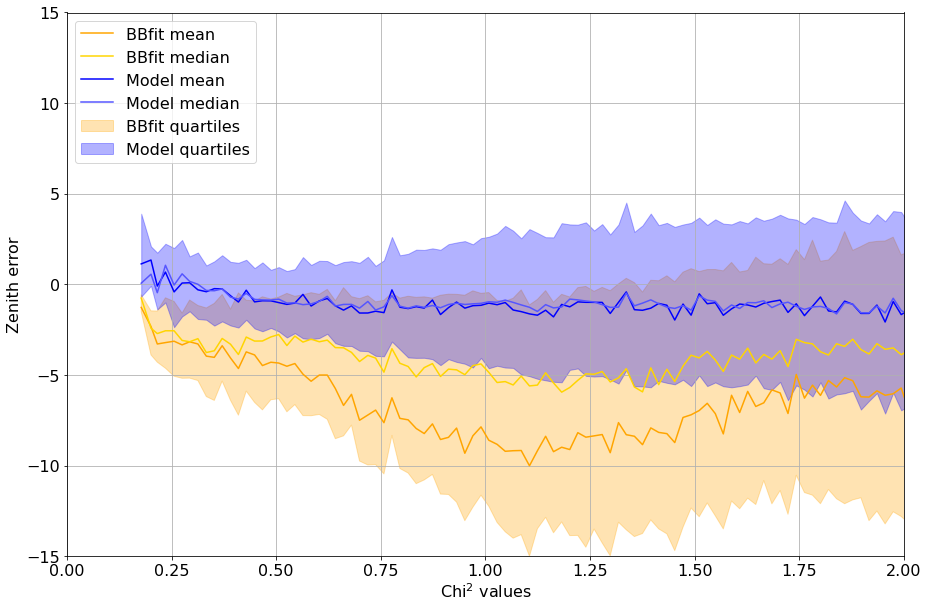

In [22]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,10))

# Mascara para coger solo los valores de chi^2 inferiores a 20
msk_txi2 = txi2<=2.1
value = txi2[msk_txi2]

# Numero de intervalos en los que agrupo los datos
n_bins = 100 

x, y, x_err, y_err = smooth_values (value, bbfit_z_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median(value, bbfit_z_error[msk_txi2], n_bins)
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, z_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median(value, z_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-15, 15)
plt.xlim(0, 2)
plt.ylabel('Zenith error')
plt.xlabel('Chi$^2$ values')
plt.legend(("BBfit mean","BBfit median", "Model mean","Model median",'BBfit quartiles', 'Model quartiles'),loc='upper left')
plt.grid()

# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/chi2_Zenith.png')
plt.show(); #muestro las figuras

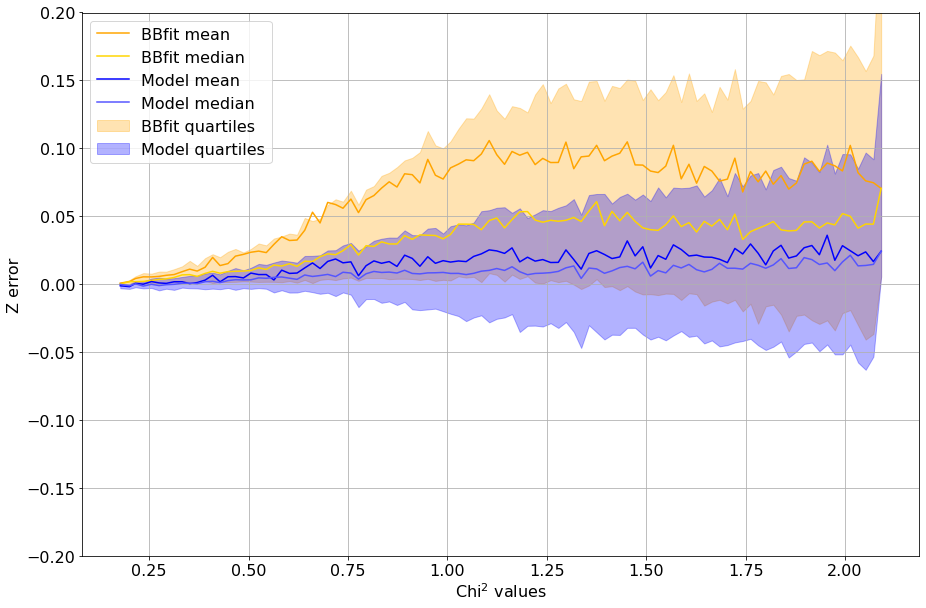

In [23]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,10))

# Mascara para coger solo los valores de chi^2 inferiores a 20
msk_txi2 = txi2<=2.1
value = txi2[msk_txi2]

# Numero de intervalos en los que agrupo los datos
n_bins = 100 

x, y, x_err, y_err = smooth_values (value, bbfit_zeta_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median(value, bbfit_zeta_error[msk_txi2], n_bins)
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, zeta_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median(value, zeta_error[msk_txi2], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-0.2, 0.2)
plt.ylabel('Z error')
plt.xlabel('Chi$^2$ values')
plt.legend(("BBfit mean","BBfit median", "Model mean","Model median",'BBfit quartiles', 'Model quartiles'),loc='upper left')
plt.grid()

# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/chi2_Z.png')
plt.show(); #muestro las figuras

### Plot de PI
#### Plot de epsilon

[1.3044535 1.675255  1.723681  1.7899083 1.8100593 1.8165648 1.824736
 1.8276724 1.841745  1.9017385 1.9624647 2.016007  2.084317  2.138532
 2.2064886 2.2606735 2.3278575 2.3911831 2.453811  2.5171003 2.5774448
 2.639554  2.6952705 2.7632048 2.823235  2.8872101 2.9471848 3.0091772
 3.0711427 3.133135  3.1945746 3.2557468 3.318998  3.3814313 3.4408197
 3.5021408 3.5644288 3.6267426 3.6895518 3.7520912 3.8134284 3.875239
 3.9366713 3.998158  4.0610113 4.123142  4.185774  4.247375  4.3085046
 4.370989  4.4321365 4.4950757 4.5567746 4.6183386 4.6807237 4.7418118
 4.8036633 4.865657  4.9284663 4.989761  5.052205  5.1139007 5.1757727
 5.238589  5.3010125 5.361947  5.4235177 5.4852743 5.5473266 5.60975
 5.6712008 5.734594  5.7956233 5.857879  5.9194865 5.981302  6.0452824
 6.107181  6.167358  6.2285604 6.291355  6.3539095 6.415536  6.4768786
 6.5398383 6.6008644 6.663379  6.7261896 6.7866497 6.8500786 6.9098606
 6.972346  7.033097  7.095204  7.1585917 7.2216134 7.281571  7.34281
 7.4071345 7.

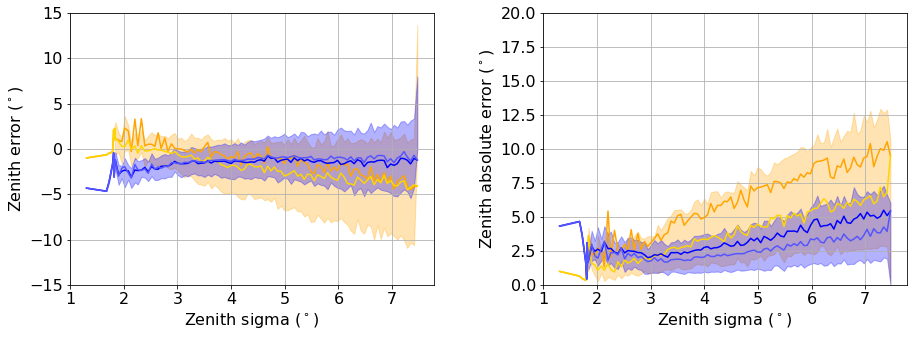

In [24]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)

z_msk = np.abs(zenith_std) < np.sort(np.abs(zenith_std))[casos]

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (zenith_std[z_msk], bbfit_z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], bbfit_z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zenith_std[z_msk], z_error[z_msk], n_bins) #cojo los valores
print(x)
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-15, 15)
plt.ylabel('Zenith error ($^\circ$)')
plt.xlabel('Zenith sigma ($^\circ$)')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
x, y, x_err, y_err = smooth_values (zenith_std[z_msk], bbfit_z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], bbfit_z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1, color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zenith_std[z_msk], z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zenith_std[z_msk], z_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1, color='blue',alpha=0.3)

#plt.fill_between(x, y+y_err,y-y_err,color='blue',alpha=0.3)
plt.ylim(0, 20)
plt.ylabel('Zenith absolute error ($^\circ$)')
plt.xlabel('Zenith sigma ($^\circ$)')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/eps_Zenith.png')
plt.show(); #muestro las figuras

[0.00042357 0.00172257 0.00269649 0.00369978 0.00477198 0.00583078
 0.0069005  0.00805395 0.00911671 0.01017744 0.01122345 0.012301
 0.01335022 0.01443959 0.01552474 0.01660074 0.01764892 0.01874406
 0.01979843 0.02086819 0.02192206 0.02300624 0.02409492 0.02516975
 0.02623713 0.0273193  0.0283854  0.02947679 0.03052975 0.03161419
 0.03267818 0.03376368 0.03483971 0.03590831 0.03699951 0.03802626
 0.03912988 0.04021306 0.04125656 0.04234075 0.04340625 0.04451501
 0.04557132 0.04662915 0.04773529 0.04877307 0.04985102 0.0509381
 0.05200617 0.05306432 0.05415809 0.05523317 0.05629198 0.05737083
 0.05843081 0.05951805 0.06058712 0.06169519 0.06275112 0.0638108
 0.06489621 0.06597852 0.06704875 0.06812636 0.06917407 0.07025629
 0.07133218 0.0724216  0.07348794 0.07455844 0.0756353  0.07671737
 0.07776634 0.07886812 0.07991964 0.08101242 0.08208492 0.08312126
 0.0842123  0.08529815 0.08636188 0.08743124 0.08849216 0.08958134
 0.09065597 0.09175054 0.09280087 0.09386635 0.09496788 0.0960323


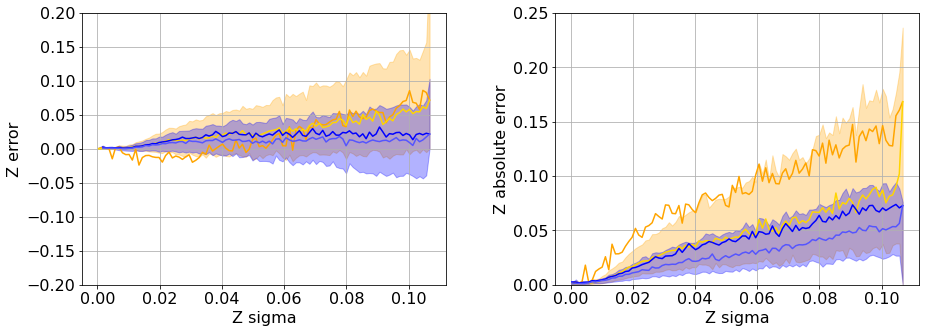

In [25]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)

z_msk = np.abs(zeta_std) < np.sort(np.abs(zeta_std))[casos]

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (zeta_std[z_msk], bbfit_zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], bbfit_zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zeta_std[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x[1:], y[1:], 'blue')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x[1:], y[1:], '#5555ff')
plt.fill_between(x, q3,q1,color='blue',alpha=0.3)

plt.ylim(-0.2, 0.2)
plt.ylabel('Z error')
plt.xlabel('Z sigma')
#plt.legend(("Model (ReLU) error", 'Model(ReLU) error deviation'),loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)
x, y, x_err, y_err = smooth_values (zeta_std[z_msk], bbfit_zeta_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'orange')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], bbfit_zeta_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3,q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (zeta_std[z_msk], zeta_error_abs[z_msk], n_bins) #cojo los valores
print(x)
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zeta_std[z_msk], zeta_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3,q1,color='blue',alpha=0.3)

plt.ylim(0, 0.25)
plt.ylabel('Z absolute error')
plt.xlabel('Z sigma')
#plt.legend(("Model (ReLU) error", 'Model(ReLU) error deviation'),loc='upper right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/eps_Z.png')
plt.show(); #muestro las figuras

### Histogramas 2D: error vs PI/Epsilon

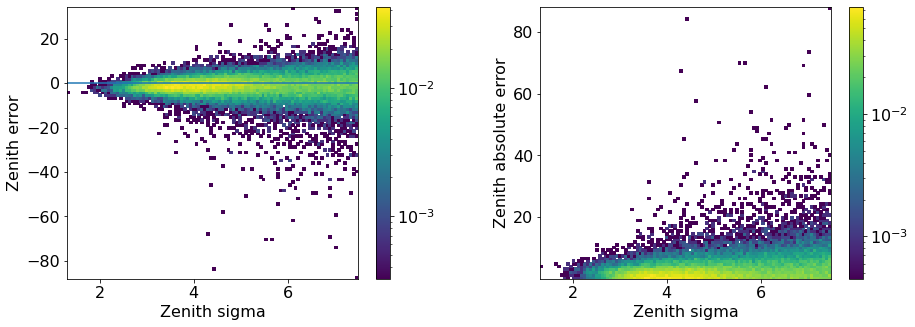

In [26]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)
z_msk = np.abs(zenith_std) < np.sort(np.abs(zenith_std))[casos]

plt.subplot(1, 2, 1)
plt.hist2d(zenith_std[z_msk], z_error[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), (0,0))
plt.ylabel('Zenith error')
plt.xlabel('Zenith sigma')
plt.colorbar()


plt.subplot(1, 2, 2)
plt.hist2d(zenith_std[z_msk], z_error_abs[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.ylabel('Zenith absolute error')
plt.xlabel('Zenith sigma')
plt.colorbar()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/colors_eps_Zenith.png')
plt.show(); #muestro las figuras

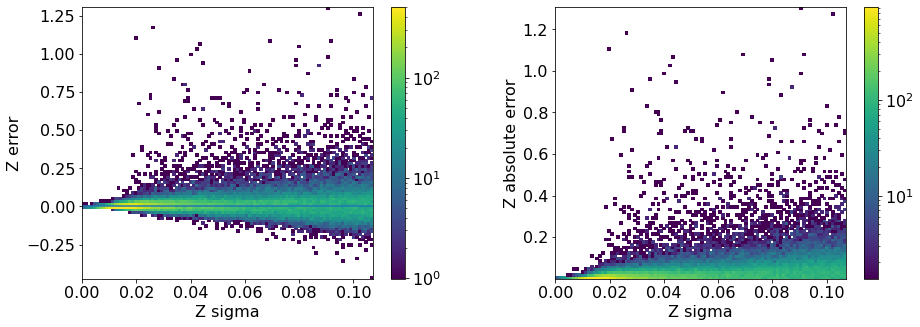

In [27]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

msk_txi2 = txi2<=2.0
casos = np.sum(msk_txi2)
z_msk = np.abs(zeta_std) < np.sort(np.abs(zeta_std))[casos]

plt.subplot(1, 2, 1)
plt.hist2d(zeta_std[z_msk], zeta_error[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), (0,0))
plt.ylabel('Z error')
plt.xlabel('Z sigma')
plt.colorbar()


plt.subplot(1, 2, 2)
plt.hist2d(zeta_std[z_msk], zeta_error_abs[z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.ylabel('Z absolute error')
plt.xlabel('Z sigma')
plt.colorbar()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/colors_eps_Z.png')
plt.show(); #muestro las figuras

### Plots de energías

Porcentaje de eventos con energía inferior a 1000: 81.63%


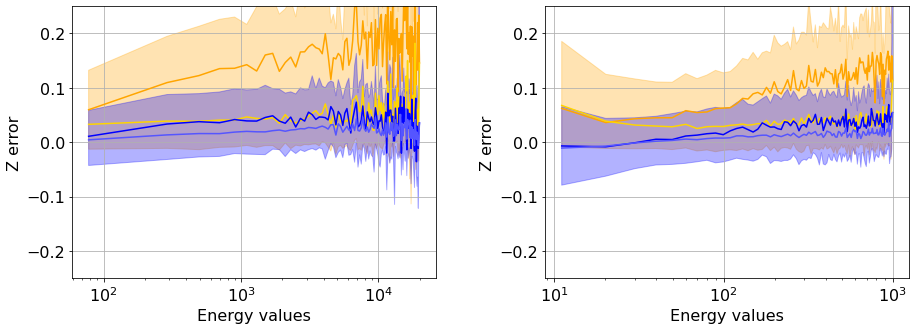

In [28]:
plt.close('all')
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 16})

msk_energ = energy<=1000
n_bins = 100

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (energy, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy, zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy, zeta_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-0.25, 0.25)
plt.ylabel('Z error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
pct = np.sum(msk_energ)/len(msk_energ)*100.0
print('Porcentaje de eventos con energía inferior a 1000: '+str(round(pct,2))+'%')

x, y, x_err, y_err = smooth_values (energy[msk_energ], bbfit_zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy[msk_energ], bbfit_zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy[msk_energ], zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy[msk_energ], zeta_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-0.25, 0.25)
plt.ylabel('Z error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig(str(folder_fig)+'/energy.png')
plt.show(); #muestro las figuras

Porcentaje de eventos con energía inferior a 1000: 81.63%


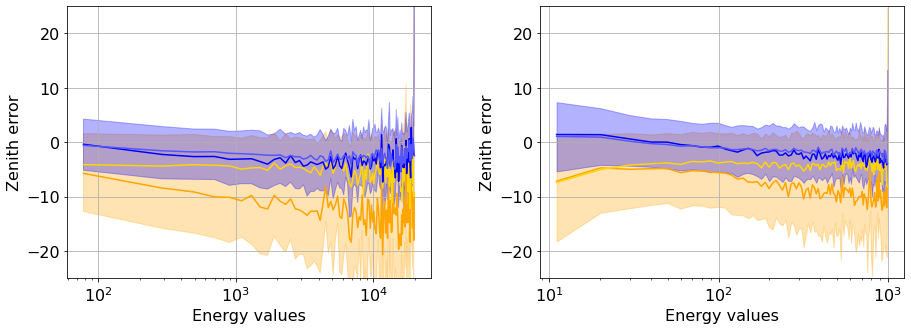

In [29]:
plt.close('all')
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 16})

msk_energ = energy<=1000
n_bins = 100

plt.subplot(1, 2, 1)
x, y, x_err, y_err = smooth_values (energy, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy, z_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy, z_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
pct = np.sum(msk_energ)/len(msk_energ)*100.0
print('Porcentaje de eventos con energía inferior a 1000: '+str(round(pct,2))+'%')

x, y, x_err, y_err = smooth_values (energy[msk_energ], bbfit_z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (energy[msk_energ], bbfit_z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (energy[msk_energ], z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (energy[msk_energ], z_error[msk_energ], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.xscale("log")
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Energy values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='lower right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig(str(folder_fig)+'/energy_zenith.png')
plt.show(); #muestro las figuras

### Plot de PI en función de Z/Zenith

In [30]:
zenith_p.shape = (test_data.get_len())

print(zenith_p.shape)
print(zenith_std.shape)

(121000,)
(121000, 1)


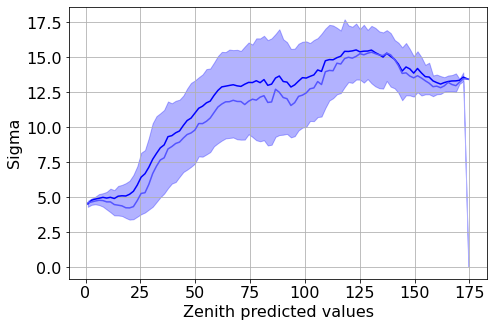

In [31]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(7.5,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

x, y, x_err, y_err = smooth_values (zenith_p, zenith_std, n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zenith_p, zenith_std, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

#plt.ylim(0.0, 25.0)
plt.ylabel('Sigma')
plt.xlabel('Zenith predicted values')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/epsilon_PI_Zenith.png')
plt.show(); #muestro las figuras

In [32]:
zeta.shape = (test_data.get_len())

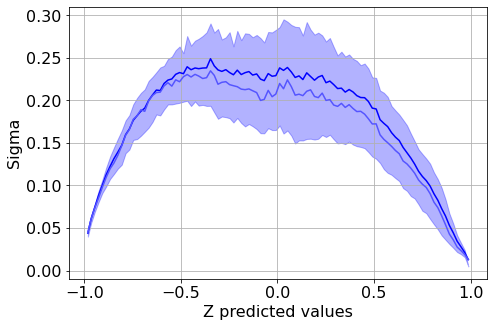

In [33]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(7.5,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

x, y, x_err, y_err = smooth_values (zeta, zeta_std, n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (zeta, zeta_std, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

#plt.ylim(0.0, 0.15)
plt.ylabel('Sigma')
plt.xlabel('Z predicted values')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()


# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/epsilon_PI_Z.png')
plt.show(); #muestro las figuras

### Plots en función de Zeta

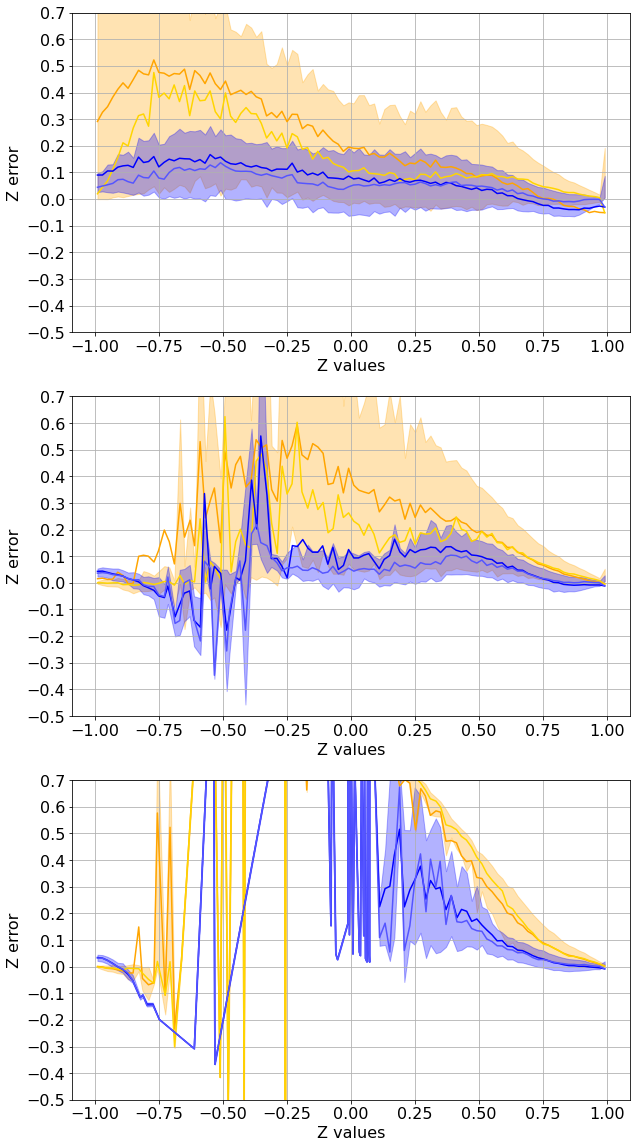

In [34]:
plt.close('all')
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 16})

value = true_z
true_z.shape = (test_data.get_len())
n_bins = 100

plt.subplot(3, 1, 1)
x, y, x_err, y_err = smooth_values (value, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value, bbfit_zeta_error, n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, zeta_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value, zeta_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-0.5, 0.7, num=13, endpoint=True ))
plt.ylim(-0.5, 0.7)
plt.ylabel('Z error')
plt.xlabel('Z values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.5
casos = int(pct*len(mu_temp))

z_msk = zeta_std < np.sort(zeta_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]
z_msk.shape = (test_data.get_len())
z_msk_bb.shape = (test_data.get_len())


plt.subplot(3, 1, 2)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-0.5, 0.7, num=13, endpoint=True ))
plt.ylim(-0.5, 0.7)
plt.ylabel('Z error')
plt.xlabel('Z values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.25
casos = int(pct*len(mu_temp))

z_msk = zeta_std < np.sort(zeta_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]
z_msk.shape = (test_data.get_len())
z_msk_bb.shape = (test_data.get_len())

plt.subplot(3, 1, 3)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_zeta_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], zeta_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-0.5, 0.7, num=13, endpoint=True ))
plt.ylim(-0.5, 0.7)
plt.ylabel('Z error')
plt.xlabel('Z values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

plt.savefig(str(folder_fig)+'/zeta.png')
plt.show(); #muestro las figuras

### Plots de Zenith

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.p

IndexError: ignored

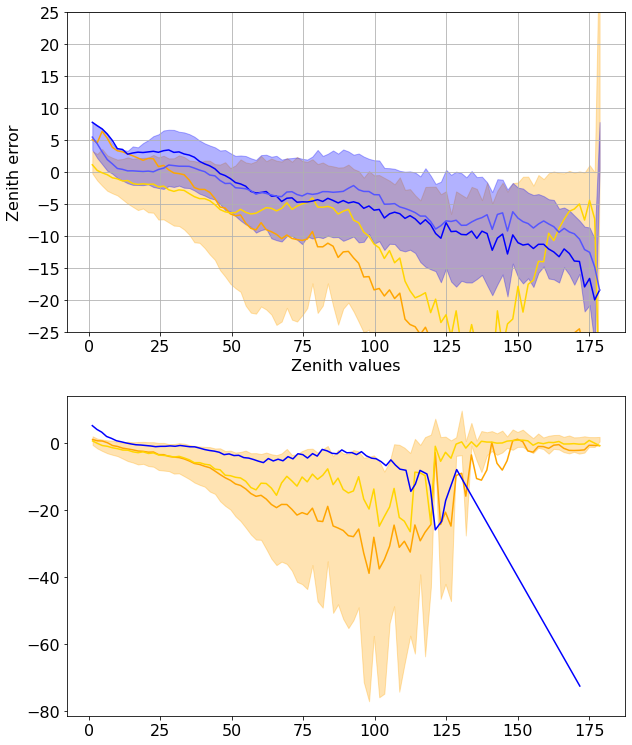

In [35]:
plt.close('all')
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 16})

value = zenith_t
value.shape = (test_data.get_len())
n_bins = 100

plt.subplot(3, 1, 1)
x, y, x_err, y_err = smooth_values (value, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value, bbfit_z_error, n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value, z_error, n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value, z_error, n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-25, 25, num=11, endpoint=True ))
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Zenith values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.5
casos = int(pct*len(mu_temp))

z_msk = zenith_std < np.sort(zenith_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]
z_msk.shape = (test_data.get_len())
z_msk_bb.shape = (test_data.get_len())

plt.subplot(3, 1, 2)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-25, 25, num=11, endpoint=True ))
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Zenith values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

pct = 0.25
casos = int(pct*len(mu_temp))

z_msk = zenith_std < np.sort(zenith_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]
#z_msk.shape = (121000)
#z_msk_bb.shape = (121000)

plt.subplot(3, 1, 3)
x, y, x_err, y_err = smooth_values (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y,'orange')
x, y, q1, q3 = smooth_median (value[z_msk_bb], bbfit_z_error[z_msk_bb], n_bins) #cojo los valores
plt.plot(x, y, '#ffd500')
plt.fill_between(x, q3, q1,color='orange',alpha=0.3)

x, y, x_err, y_err = smooth_values (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y,'blue')
x, y, q1, q3 = smooth_median (value[z_msk], z_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.yticks(np.linspace(-25, 25, num=11, endpoint=True ))
plt.ylim(-25, 25)
plt.ylabel('Zenith error')
plt.xlabel('Zenith values')
#plt.legend(("BBfit error","Model (ReLU) error",'BBfit error deviation', 'Model (ReLU) error deviation'),loc='upper right')
plt.grid(which='both')

plt.savefig(str(folder_fig)+'/zenith.png')
plt.show(); #muestro las figuras

### Density Plot Zenith

In [36]:
z_error_abs.shape = (test_data.get_len())
bbfit_z_error_abs.shape = (test_data.get_len())

zenith
ReLU avg: 7.9552, BBfit avg: 15.5067
ReLU std: 9.0708, BBfit std: 18.9082
#####################
Zeta
ReLU avg: 0.1021, BBfit avg: 0.1982
ReLU std: 0.1314, BBfit std: 0.2714
Zenith median:  4.910300108965101 

Zenith mean:  7.955152784846118 

Zenith quartiles:  2.0950459997072954 10.366781324556532 

#####################
60500 121000 0.5
8.07556146704327
#####################
Zeta
ReLU avg: 0.0378, BBfit avg: 0.1008
ReLU std: 0.0529, BBfit std: 0.1564
Zenith median for 0.5 bests sigmas:  2.664509128837139 

Zenith mean for 0.5 bests sigmas:  3.747192681924874 

Zenith quartiles for 0.5 bests sigmas:  1.2231108823076955 4.912204572681141 



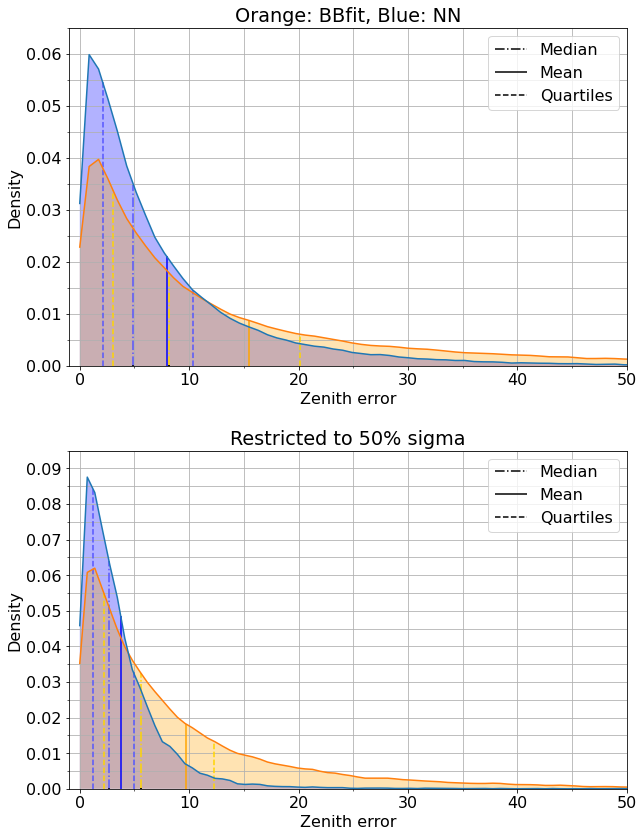

In [37]:
import seaborn as sns
import scipy

plt.close('all')
plt.figure(figsize=(10,14))

print('zenith')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(z_error_abs), np.average(bbfit_z_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(z_error_abs), np.std(bbfit_z_error_abs)))
print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs), np.average(bbfit_zeta_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs), np.std(bbfit_zeta_error_abs)))

plt.subplot(2, 1, 1)

p = sns.kdeplot(data=[z_error_abs,bbfit_z_error_abs],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(z_error_abs)
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashdot', color='black', label='Median')
print('Zenith median: ', median,'\n')

median = np.median(bbfit_z_error_abs)
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(z_error_abs)
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.0001, color='black', label='Mean')
print('Zenith mean: ', mean,'\n')

mean = np.mean(bbfit_z_error_abs)
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(z_error_abs,0.25), np.quantile(z_error_abs,0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashed', color='black', label='Quartiles')
print('Zenith quartiles: ', q1,q3,'\n')

q1, q3 = np.quantile(bbfit_z_error_abs,0.25), np.quantile(bbfit_z_error_abs,0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-1,50)
plt.gca().set_ylim(0.0,0.065)
plt.gca().set_title('Orange: BBfit, Blue: NN')
plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 0.06, num=7, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 0.065, num=14, endpoint=True ),minor=True)
plt.xlabel('Zenith error')
plt.grid(which='both',b=True)
plt.legend()


plt.subplot(2, 1, 2)

pct = 0.5
casos = int(pct*len(mu_temp))
print('#####################')
print(casos, len(mu_temp), casos/len(mu_temp))

z_msk = zenith_std < np.sort(zenith_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]
z_msk.shape = (121000)
z_msk_bb.shape = (121000)

print(zenith_std[z_msk].max())

print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs[z_msk]), np.average(bbfit_zeta_error_abs[z_msk_bb])))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs[z_msk]), np.std(bbfit_zeta_error_abs[z_msk_bb])))

p = sns.kdeplot(data=[z_error_abs[z_msk],bbfit_z_error_abs[z_msk_bb]],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(z_error_abs[z_msk])
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashdot', color='black', label='Median')
print('Zenith median for 0.5 bests sigmas: ', median,'\n')

median = np.median(bbfit_z_error_abs[z_msk_bb])
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(z_error_abs[z_msk])
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.0001, color='black', label='Mean')
print('Zenith mean for 0.5 bests sigmas: ', mean,'\n')

mean = np.mean(bbfit_z_error_abs[z_msk_bb])
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(z_error_abs[z_msk],0.25), np.quantile(z_error_abs[z_msk],0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.0001,linestyles='dashed', color='black', label='Quartiles')
print('Zenith quartiles for 0.5 bests sigmas: ', q1, q3,'\n')

q1, q3 = np.quantile(bbfit_z_error_abs[z_msk_bb],0.25), np.quantile(bbfit_z_error_abs[z_msk_bb],0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-1,50)
plt.gca().set_ylim(0.0,0.095)
plt.gca().set_title('Restricted to 50% sigma')
plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 0.095, num=20, endpoint=True ),minor=True)
plt.gca().set_yticks(np.linspace(0, 0.09, num=10, endpoint=True ))
plt.xlabel('Zenith error')
plt.grid(which='both',b=True)
plt.legend()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig(str(folder_fig)+'/density_Zenith.png')
plt.show;


In [38]:
z_error.shape = (test_data.get_len())
z_error_abs.shape = (test_data.get_len())
bbfit_zeta_error.shape = (test_data.get_len())
bbfit_zeta_error_abs.shape = (test_data.get_len())
zeta_error_abs.shape=(test_data.get_len())

Zenith
ReLU avg: 7.9552, BBfit avg: 15.5067
ReLU std: 9.0708, BBfit std: 18.9082
#####################
Zeta
ReLU avg: 0.1021, BBfit avg: 0.1982
ReLU std: 0.1314, BBfit std: 0.2714
#####################
60500 121000 0.5
#####################
Zeta
ReLU avg: 0.0488, BBfit avg: 0.1008
ReLU std: 0.0682, BBfit std: 0.1564


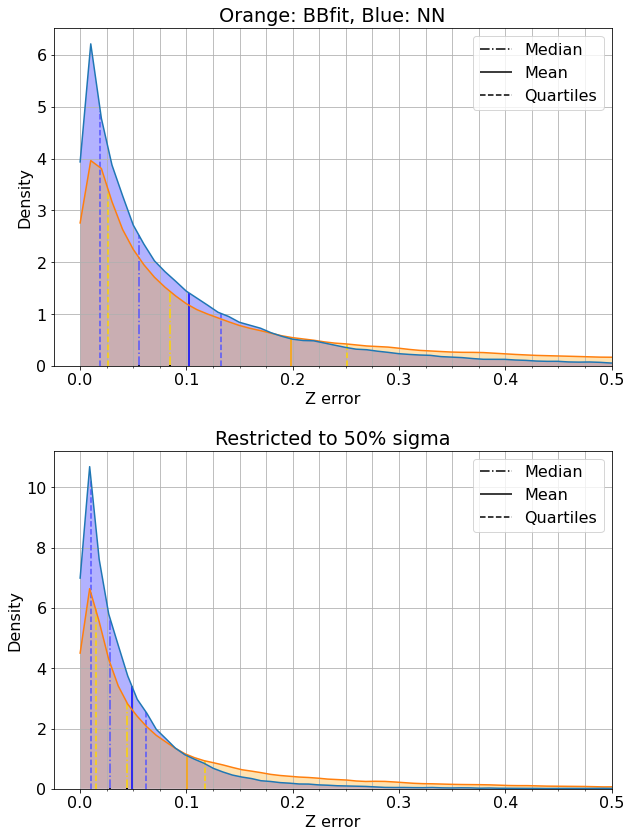

In [40]:
import seaborn as sns
import scipy

plt.close('all')
plt.figure(figsize=(10,14))

print('Zenith')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(z_error_abs), np.average(bbfit_z_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(z_error_abs), np.std(bbfit_z_error_abs)))
print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs), np.average(bbfit_zeta_error_abs)))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs), np.std(bbfit_zeta_error_abs)))

plt.subplot(2, 1, 1)

p = sns.kdeplot(data=[zeta_error_abs,bbfit_zeta_error_abs],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(zeta_error_abs)
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashdot', color='black', label='Median')

median = np.median(bbfit_zeta_error_abs)
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(zeta_error_abs)
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.01, color='black', label='Mean')

mean = np.mean(bbfit_zeta_error_abs)
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(zeta_error_abs,0.25), np.quantile(zeta_error_abs,0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashed', color='black', label='Quartiles')

q1, q3 = np.quantile(bbfit_zeta_error_abs,0.25), np.quantile(bbfit_zeta_error_abs,0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-0.025,0.5)
plt.gca().set_title('Orange: BBfit, Blue: NN')
plt.gca().set_xticks(np.linspace(0, 0.5, num=21, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 0.5, num=6, endpoint=True ))
plt.xlabel('Z error')
plt.grid(which='both',b=True)
plt.legend()


plt.subplot(2, 1, 2)

pct = 0.5
casos = int(pct*len(mu_temp))
print('#####################')
print(casos, len(mu_temp), casos/len(mu_temp))

z_msk = zeta_std < np.sort(zeta_std)[casos]
z_msk_bb = txi2 < np.sort(txi2)[casos]
z_msk.shape = (121000)
z_msk_bb.shape = (121000)

print('#####################')
print('Zeta')
print("ReLU avg: %.4f, BBfit avg: %.4f" % (np.average(zeta_error_abs[z_msk]), np.average(bbfit_zeta_error_abs[z_msk_bb])))
print("ReLU std: %.4f, BBfit std: %.4f" % (np.std(zeta_error_abs[z_msk]), np.std(bbfit_zeta_error_abs[z_msk_bb])))

p = sns.kdeplot(data=[zeta_error_abs[z_msk],bbfit_zeta_error_abs[z_msk_bb]],cut=0,common_grid=True,common_norm=True, bw_adjust=0.4)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='orange', alpha=0.3)

# Medians
median = np.median(zeta_error_abs[z_msk])
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashdot', color='black', label='Median')

median = np.median(bbfit_zeta_error_abs[z_msk_bb])
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#ffd500')

#Means
mean = np.mean(zeta_error_abs[z_msk])
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.01, color='black', label='Mean')

mean = np.mean(bbfit_zeta_error_abs[z_msk_bb])
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='orange')

#Quartiles
q1, q3 = np.quantile(zeta_error_abs[z_msk],0.25), np.quantile(zeta_error_abs[z_msk],0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.01,linestyles='dashed', color='black', label='Quartiles')

q1, q3 = np.quantile(bbfit_zeta_error_abs[z_msk_bb],0.25), np.quantile(bbfit_zeta_error_abs[z_msk_bb],0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#ffd500')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#ffd500')

plt.gca().set_xlim(-0.025,0.5)
plt.gca().set_title('Restricted to 50% sigma')
plt.gca().set_xticks(np.linspace(0, 0.5, num=21, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 0.5, num=6, endpoint=True ))
plt.xlabel('Z error')
plt.grid(which='both',b=True)
plt.legend()


plt.subplots_adjust(hspace=0.25,wspace=0.3)
plt.savefig(str(folder_fig)+'/density_Z.png')
plt.show;

### Histogramas de Z

60500 121000 0.5
30250 121000 0.25


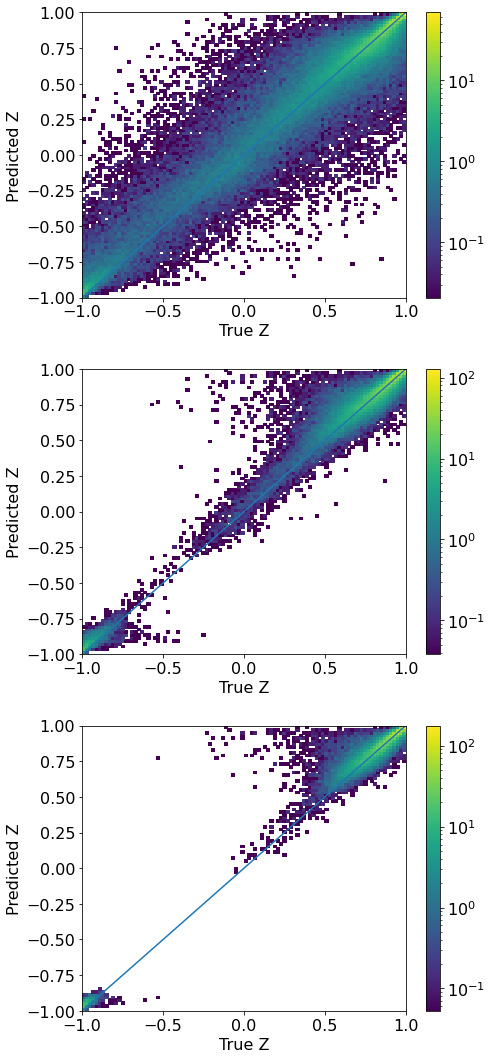

In [41]:
# Histograma de Z cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(true_z, zeta, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_std < np.sort(zeta_std)[casos]
Z_msk.shape = (test_data.get_len())

plt.subplot(3, 1, 2)
plt.hist2d(true_z[Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_std < np.sort(zeta_std)[casos]
Z_msk.shape = (test_data.get_len())


plt.subplot(3, 1, 3)
plt.hist2d(true_z[Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_Z_eps.png')
plt.show(); #muestro las figuras

60500 121000 0.5
30250 121000 0.25


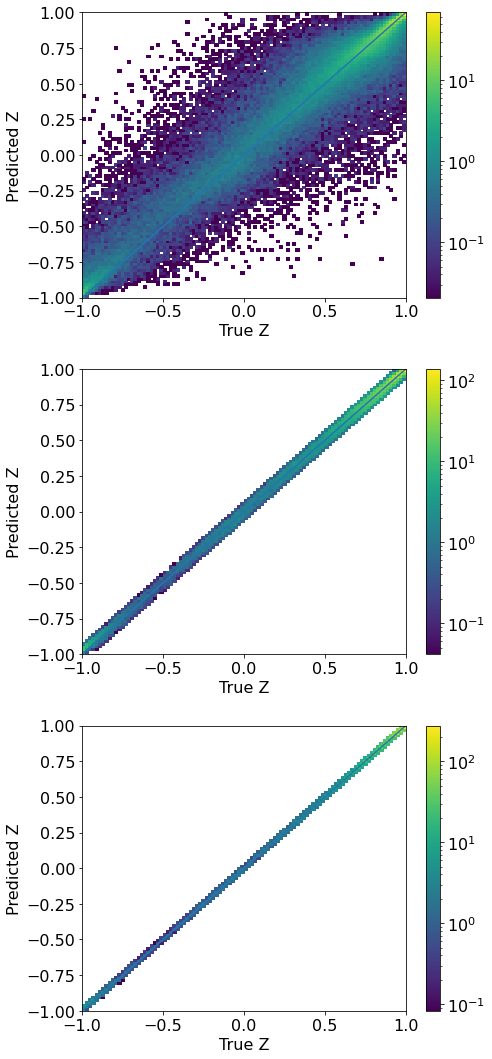

In [42]:
# Histograma de Z cortado con error
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(true_z, zeta, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_error_abs < np.sort(zeta_error_abs)[casos]
Z_msk.shape = (test_data.get_len())

plt.subplot(3, 1, 2)
plt.hist2d(true_z[Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = zeta_error_abs < np.sort(zeta_error_abs)[casos]
Z_msk.shape = (test_data.get_len())

plt.subplot(3, 1, 3)
plt.hist2d(true_z[Z_msk], zeta[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_Z_error.png')
plt.show(); #muestro las figuras

### Histogramas 2D de zenith

18.963636363636365
72.14876033057851


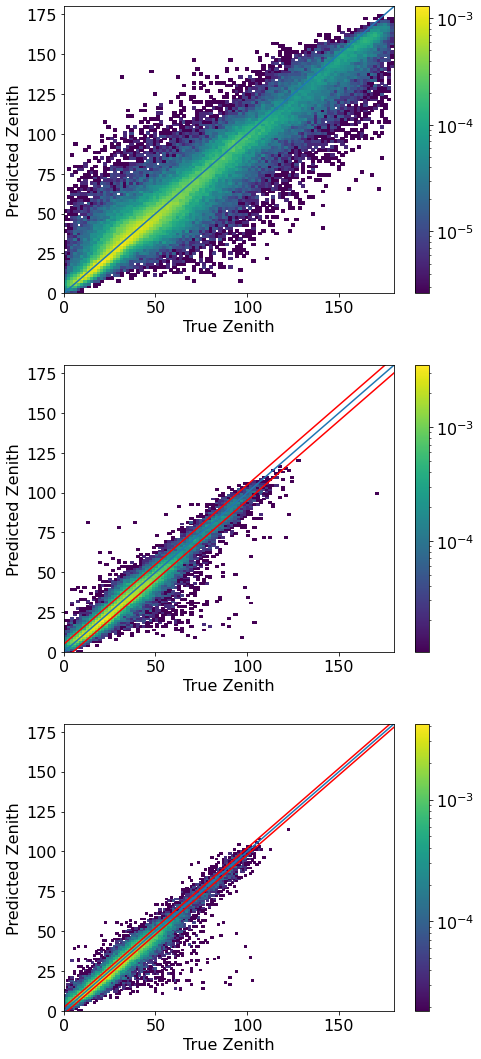

In [43]:
#histograma de zenith cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(zenith_t, zenith_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.50
casos = int(pct*len(mu_temp))

Z_msk = zenith_std < np.sort(zenith_std)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()
Z_msk.shape = (test_data.get_len())

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 2)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim()+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.25
casos = int(pct*len(mu_temp))

Z_msk = zenith_std < np.sort(zenith_std)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()
Z_msk.shape = (121000)

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 3)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim()+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_Zenith_eps.png')
plt.show(); #muestro las figuras

60500 121000 0.5
30250 121000 0.25
2.095020273918415


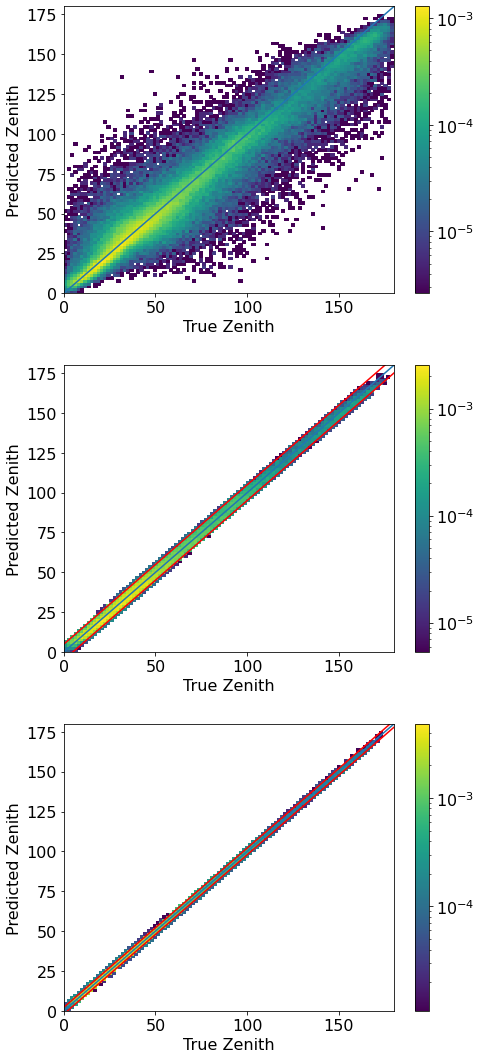

In [44]:
#histograma de zenith cortado con error
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(zenith_t, zenith_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.50
casos = int(pct*len(mu_temp))
print(casos, len(mu_temp), casos/len(mu_temp))

Z_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[Z_msk].max()
Z_msk.shape = (121000)

plt.subplot(3, 1, 2)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(plt.gca().get_xlim()+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.25
casos = int(pct*len(mu_temp))
print(casos, len(mu_temp), casos/len(mu_temp))

Z_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[Z_msk].max()
Z_msk.shape = (121000)
print(a)

plt.subplot(3, 1, 3)
plt.hist2d(zenith_t[Z_msk],zenith_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())

plt.plot((0,180)+a,plt.gca().get_ylim(), color='red')
plt.plot(plt.gca().get_xlim()-a,plt.gca().get_ylim(), color='red')

plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_Zenith_error.png')
plt.show(); #muestro las figuras

### Histogramas de Z BB

In [45]:
bbfit_z_p.shape = (test_data.get_len())

60500 121000 0.5
38.99173553719008
30250 121000 0.25
61.920661157024796


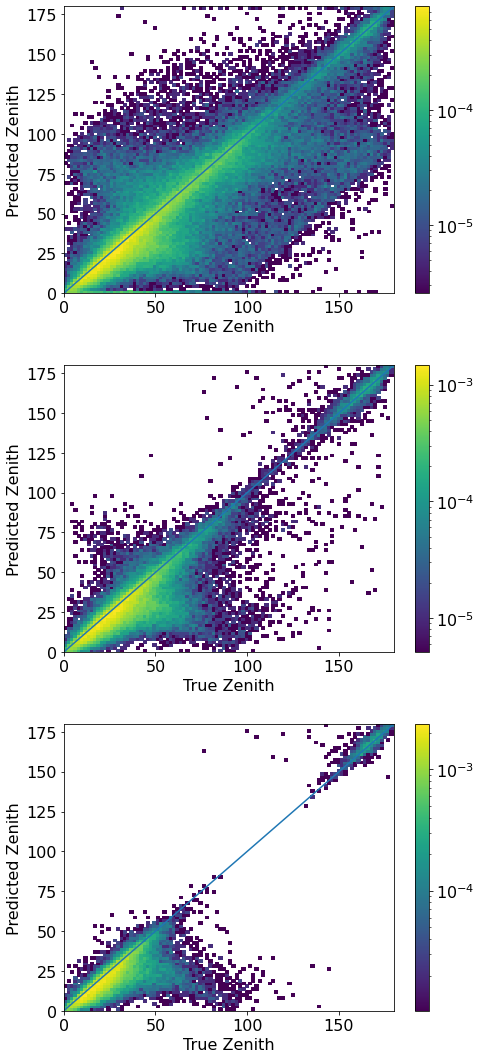

In [46]:
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(zenith_t, bbfit_z_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.50
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()
Z_msk.shape = (121000)

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 2)
plt.hist2d(zenith_t[Z_msk], bbfit_z_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

pct = 0.25
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]
a_msk = z_error_abs < np.sort(z_error_abs)[casos]
a = z_error_abs[a_msk].max()
Z_msk.shape = (121000)

print(np.sum(z_error_abs[Z_msk]> a)*100/casos)

plt.subplot(3, 1, 3)
plt.hist2d(zenith_t[Z_msk], bbfit_z_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(0,180)
plt.ylim(0,180)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Zenith')
plt.xlabel('True Zenith')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_Zenith_bb.png')
plt.show(); #muestro las figuras

In [47]:
bbfit_uz.shape = (test_data.get_len())

60500 121000 0.5
30250 121000 0.25


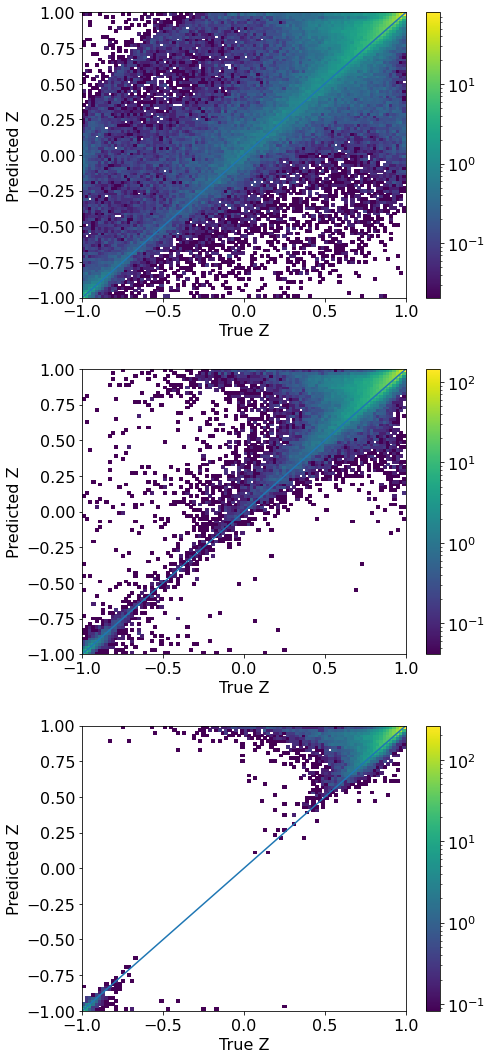

In [48]:
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

n_bins = 100

plt.subplot(3, 1, 1)
plt.hist2d(true_z, bbfit_uz, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.50
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(true_z[Z_msk], bbfit_uz[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(bbfit_uz))
print(casos, len(bbfit_uz), casos/len(bbfit_uz))

Z_msk = txi2< np.sort(txi2)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(true_z[Z_msk], bbfit_uz[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_Z_bb.png')
plt.show(); #muestro las figuras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


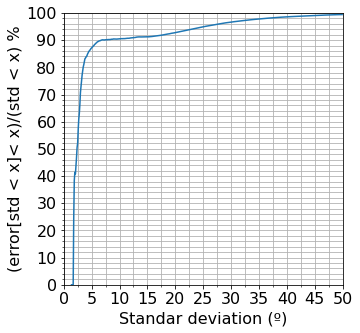

In [49]:
plt.close('all')
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 16})

x = np.arange(1,50,0.1)
y = np.zeros(x.shape)

z_error_abs.shape=(test_data.get_len(),1)

count = 0
for i in x:
    y[count] = np.sum(z_error_abs[zenith_std<i] < i)*100/np.sum(zenith_std < i)
    count += 1

plt.plot(x,y)
plt.xlim(0,50)
plt.ylim(0,100)
plt.ylabel('(error[std < x]< x)/(std < x) %')
plt.xlabel('Standar deviation (º)')

plt.gca().set_xticks(np.linspace(0, 50, num=21, endpoint=True ),minor=True)
plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ))
plt.gca().set_yticks(np.linspace(0, 100, num=51, endpoint=True ),minor=True)
plt.gca().set_yticks(np.linspace(0, 100, num=11, endpoint=True ))
plt.grid(which='both',b=True)

plt.show();